# Model Analysis Project

Imports and set magics:

In [106]:
import numpy as np
from scipy import optimize
import sympy as sm

from IPython.display import display

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
plt.style.use('seaborn-whitegrid')
plt.rcParams.update({'font.size': 12})

# The Solow model

We consider the Solow model with an adjustable supply of labor. The model consists of the following equations:

* $Y_t = BK_t^{\alpha}L_t^{1-\alpha}$, $0<\alpha<1$
* $S_t = sY_t$, $0 < s < 1$
* $K_{t+1}-K_t = S_t\delta K_t$, $0<\delta<1$

where $K_t$ is capital today, $K_{t+1}$ is capital tomorrow, $S_t$ is savings and $Y_t$ is the output of the economy. 

We also have $L_t$ which is the supply of labor, and $N_t$ which is the size of the population today, which are defined by the following:

* $L_t=\lambda N_t$, $0<\lambda<1$
* $N_{t+1}=(1+n)N_t$

where lambda is the share of the population in work. The population is growing with a contant rate of n in every period. 

We will through this project look at capital, labor and output pr. capita:

$y_t = \frac{Y_t}{N_t} = \lambda^{(1-\alpha)}Bk_t^{\alpha}$ with $k_t = \lambda{K_t}{N_t}$

This will give us the following transformation equation of capital: 

$k_{t+1} = \frac{1}{(1+n)}(sB\lambda^{1-\alpha}k_t^{\alpha}+(1-\delta)k_t)$


# Solving the model

The first step in solwing the model is to find steady state for capital. This means solwing for $k_t = k_{t+1} = k^{*}$

First we define all of the necessary sumbols and equations of our model:

In [107]:
k = sm.symbols('k')
n = sm.symbols('n')
s = sm.symbols('s')
B = sm.symbols('B')
lam = sm.symbols('lambda')
delta = sm.symbols('delta')
alpha = sm.symbols('alpha')

steadystateK = sm.Eq(k,(s*B*lam**(1-alpha)*k**(alpha)+(1-delta)*k)/((1+n)))

We solve this using sympy: 

In [108]:
steadystateKstar = sm.solve(steadystateK,k)[0]
steadystateKstar

(B*lambda**(1 - alpha)*s/(delta + n))**(-1/(alpha - 1))

We see that the level of capital in steady state is positively dependent of the savings $s$, $B$ and the share of the population that is working. The level of capital in steady state is negatively dependent of the growth in population as well as the rate of attrition of capital $\delta$.

We also want to find the steady state for the output of the economy $y^{*}$
We know that $y_t = \lambda^{(1-\alpha)}Bk_t^{\alpha}$
To solve for $y^{*}$ we need to insert $k^{*}$ into the equation. 

In [109]:
#saving the steady state for k
ssk = sm.lambdify((B,lam,alpha,delta,n,s),steadystateKstar)

y = sm.symbols('y')
steadystateY = sm.Eq(y,lam**(1-alpha)*B*steadystateKstar**alpha)
steadystateYstar = sm.solve(steadystateY,y)[0]
steadystateYstar

B*lambda**(1 - alpha)*((B*lambda**(1 - alpha)*s/(delta + n))**(-1/(alpha - 1)))**alpha

## How will the supply of labor affect the output of the economy? (Theoretically)

To show how the supply of laber affects the output in steady state we need to take a look at lambda - the share of population in work. First we look at the elasticity of lambda. To do this we need to rewrite the steady state for $y^{*}$: 

$y^{*} = B\lambda^{(1-\alpha)}(\frac{B\lambda^{(1-\alpha)}s}{(\delta + n)})^{\frac{\alpha}{(1-\alpha)}}$

$y^{*} = \frac{B\lambda^{(1-\alpha)}B^{\frac{\alpha}{(1-\alpha)}}\lambda^{\alpha}s^{\frac{\alpha}{(1-\alpha)}}}{(\delta + n)^\frac{\alpha}{{(1-\alpha)}}}$

$y^{*} = \frac{B^{\frac{1}{(1-\alpha)}}\lambda s^{\frac{\alpha}{(1-\alpha)}}}{(\delta + n)^\frac{\alpha}{{(1-\alpha)}}}$

$y^{*} = B^{\frac{1}{(1-\alpha)}}\lambda(\frac{s}{(\delta + n)})^{\frac{\alpha}{(1-\alpha)}}$

In [110]:
ely = sm.Eq(y,B**(1/(1-alpha))*lam*(s/(delta+n))**(alpha/(1-alpha)))
ely

Eq(y, B**(1/(1 - alpha))*lambda*(s/(delta + n))**(alpha/(1 - alpha)))

To find the elasticity of $y^{*}$ with respect to lambda we take the log on both sides: 

$ln(y^{*}) = \frac{1}{1-\alpha}ln(B) + ln(\lambda) + \frac{\alpha}{1-\alpha}(ln(s) - ln(n+\delta)) $

We see that the elasticity of $y^{*}$ with respect to lambda is 1. This means that an increase in $\lambda$ with 1 pct. will result in an increase in $y^{*}$ with 1 pct. 

## How will the supply of labor affect the output of the economy? (Example)

To give an example of what the outcome of the steady state could be, we have tried to insert plausible values of the parameters. To see the effect of an increase in lambda, we have calculated the steady state value of capital two times given a share of workers being 0.6 and 0.75 which leads to the following two results:

In [112]:
print(f'The first solution with lampda = 0.6 is: {ssk(1,0.6,1/3,0.1,0.25,0.2):.3f}')
print(f'The second solution with lampda = 0.75 is: {ssk(1,0.75,1/3,0.1,0.25,0.2):.3f}')

The first solution with lampda = 0.6 is: 0.259
The second solution with lampda = 0.75 is: 0.324


As expected we get a higher level of capital the higher the share of workers relative to the population. 

# Visualization of the two solutions

We want to show the transition to steady state in a phase diagram with the two different share of workers. We do this by simulating two different transations from time 0 to steady state.

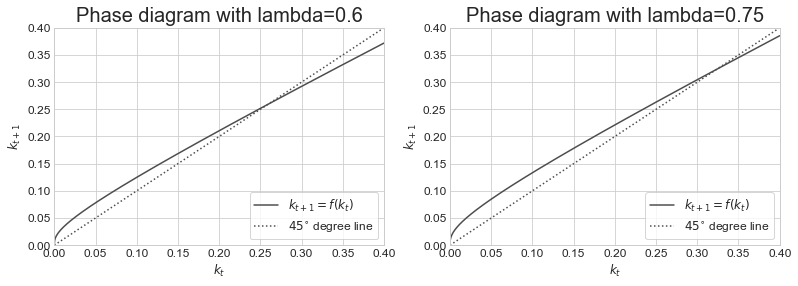

In [113]:
#Transformation equation of capital
def k_trans_one(alpha,delta,lam_one,B,s,n,k_t): 
    return 1/(1+n)*(s*B*lam_one**(1-alpha)*k_t**alpha+(1-delta)*k_t)

def k_trans_two(alpha,delta,lam_two,B,s,n,k_t): 
    return 1/(1+n)*(s*B*lam_two**(1-alpha)*k_t**alpha+(1-delta)*k_t)

#Steady state for k
def ss_k_one(alpha,delta,lam_one,B,s,n):
    return (B*lam_one**(1-alpha)*s/(delta+n))**(1/(1-alpha))
def ss_k_two(alpha,delta,lam_two,B,s,n):
    return (B*lam_two**(1-alpha)*s/(delta+n))**(1/(1-alpha))

# Setting the parameters
alpha=1/3
delta=0.1
lam_one=0.6
lam_two=0.75
B=1
n=0.25
s=0.2
k0 = 0.01

#Time periods
T = 20
index = range(T)

#Graph 1
k_level_one = np.zeros(len(index))
k_level_one[0] = k0

for t in index[1:]:
    k_level_one[t] = k_trans_one(alpha,delta,lam_one,B,s,n,k_level_one[t-1])
    
#Graph 2
k_level_two = np.zeros(len(index))
k_level_two[0] = k0

for t in index[1:]:
    k_level_two[t] = k_trans_two(alpha,delta,lam_two,B,s,n,k_level_two[t-1])
    
# Number of values in the grid
N = 1000

# Capital in period t
_k_t_one = np.linspace(0,0.4,N)
_k_t_two = np.linspace(0,0.4,N)

# Capital in period t+1
_k_trans_one = np.zeros(N)
_k_trans_two = np.zeros(N)

for i,k in enumerate(_k_t_one):
    _k_trans_one[i] = k_trans_one(alpha,delta,lam_one,B,s,n,k)

for i,k in enumerate(_k_t_two):
    _k_trans_two[i] = k_trans_two(alpha,delta,lam_two,B,s,n,k)
    
fig, axes = plt.subplots(1, 2, sharex='col', figsize=(13, 4))
ax1 = axes[0]
ax2 = axes[1]

#Phase diagram 1:

ax1.plot(_k_t_one,_k_trans_one, color='0.3',label=r'$k_{t+1} = f(k_t)$')
ax1.plot(_k_t_one,_k_t_one,color='0.3',linestyle=':', label=r'$45^{\circ}$ degree line')

ax1.set_ylabel('$k_{t+1}$')
ax1.set_xlabel('$k_t$')
ax1.set_xlim(0,0.4)
ax1.set_ylim(0,0.4)
ax1.legend(loc=4,frameon=True)

ax1.set_title('Phase diagram with lambda=0.6', fontsize=20)

#Phase diagram 2:

ax2.plot(_k_t_two,_k_trans_two, color='0.3',label=r'$k_{t+1} = f(k_t)$')
ax2.plot(_k_t_two,_k_t_two,color='0.3',linestyle=':', label=r'$45^{\circ}$ degree line')

ax2.set_ylabel('$k_{t+1}$')
ax2.set_xlabel('$k_t$')
ax2.set_xlim(0,0.4)
ax2.set_ylim(0,0.4)
ax2.legend(loc=4,frameon=True)

ax2.set_title('Phase diagram with lambda=0.75', fontsize=20)

plt.show()

# Conclusion

The conclusion of this project is that a higher share of workers will result in a higher level of capital in steady state. This higher level of capital will result in increased production. Thus if an economy seeks to have a higher level of production, it could be achieved by increasing the share of workers through lower taxes or higher wages. 